In [2]:
# f = (f' - B - d * t) / med (f' - b - d * t)
# D = D' - B
# B = B' + Berr

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
num_Of_pixels = 10 
dark_prime_per_sec_pix = 2 
flatupper = 1.3
flatlower = 0.8
bias_electrons_per_atod = 400 
atod_gain = 10
biasErrupper = 0.2
biasErrlower = 0.01
time = 300 

In [5]:
# what the flat should be
bin = num_Of_pixels * num_Of_pixels
flatPrime = np.linspace(flatlower, flatupper, bin)
# the bias per pixels 
bias = bias_electrons_per_atod * atod_gain 
biasPrime = np.linspace(bias * (1 + biasErrlower), bias * (1 + biasErrupper), bin)
# the dark that should be
darkPrime = dark_prime_per_sec_pix * time
# flat field propagation 
mean_displacement = []
for master_bias in biasPrime:  
    master_dark = darkPrime - master_bias
    flat = flatPrime - master_dark - master_bias
    flat /= np.mean(flat)
    displacement = np.mean((flat - flatPrime) / flatPrime)
    mean_displacement.append(displacement) 

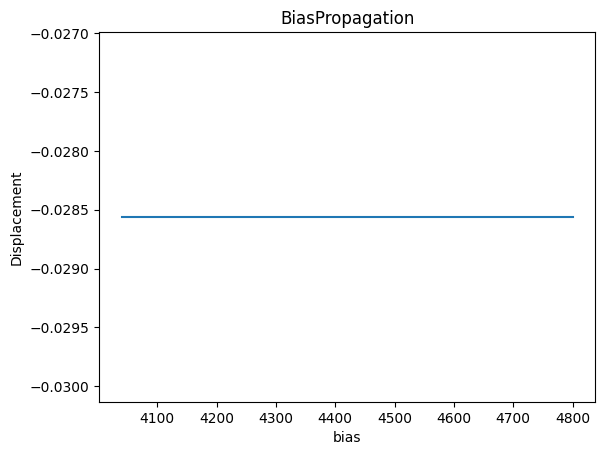

In [6]:
plt.plot(biasPrime, mean_displacement)
plt.title("BiasPropagation")
# naming the x axis
plt.xlabel('bias')
# naming the y axis
plt.ylabel('Displacement')
plt.show()